In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import sys
from imp import reload

from cca import kron_pca
from cca import synth_data

In [3]:
def disp_cov(cov, title):
    plt.imshow(cov, vmin=-1, vmax=1, cmap="RdGy")
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.show()

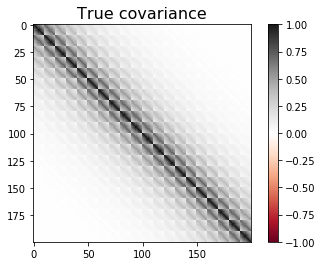

In [4]:
"""
Make a Kernel and compute true covariance matrix
"""

N = 10
num_lags = 20

K = synth_data.gen_gp_kernel(kernel_type="exp", spatial_scale=10.0, temporal_scale=3.0)

true_cov = synth_data.gen_gp_cov(num_lags, N, K)
disp_cov(true_cov, "True covariance")

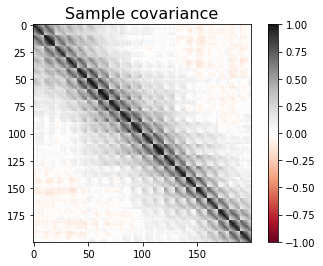

In [10]:
"""
Generate data from the kernel
"""

num_samples = 400
X_with_lags = np.random.multivariate_normal(mean=np.zeros(true_cov.shape[0]), cov=true_cov, size=num_samples)
X_with_lags -= X_with_lags.mean(axis=0)

"""
Compute sample covariance matrix
"""
    
sample_cov = np.dot(X_with_lags.T, X_with_lags)/len(X_with_lags)
disp_cov(sample_cov, "Sample covariance")

0.01 100000000.0
0.01438449888287663 100000000.0
0.0206913808111479 100000000.0
0.029763514416313176 100000000.0
0.04281332398719394 100000000.0
0.06158482110660264 100000000.0
0.08858667904100823 100000000.0
0.12742749857031335 100000000.0
0.18329807108324356 100000000.0
0.26366508987303583 100000000.0
0.37926901907322497 100000000.0
0.5455594781168517 100000000.0
0.7847599703514611 100000000.0
1.1288378916846884 100000000.0
1.623776739188721 100000000.0
2.3357214690901213 100000000.0
3.359818286283781 100000000.0
4.832930238571752 100000000.0
6.951927961775605 100000000.0
10.0 100000000.0


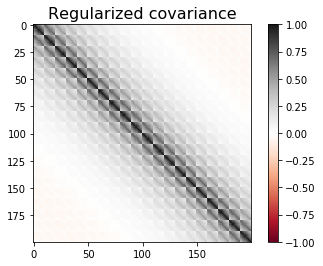

In [11]:
"""
Run cross-validated Toeplitz-Kron-PCA
"""

lambda_L_vals = np.logspace(-2, 1, 20)
lambda_S_vals = np.array([1e8])
cov_reg, log_likelihood_vals, rank_vals, sparsity_vals = kron_pca.regularize_cov(X_with_lags,
                                                                                 N, num_lags,
                                                                                 lambda_L_vals, lambda_S_vals,
                                                                                 num_folds=10,
                                                                                 tau=0.5,
                                                                                 tol=1e-8,
                                                                                 max_iter=1000000,
                                                                                 stop_cond_interval=20)

disp_cov(cov_reg, "Regularized covariance")

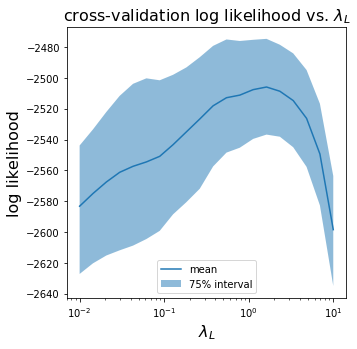

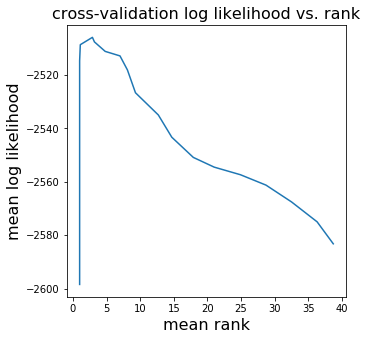

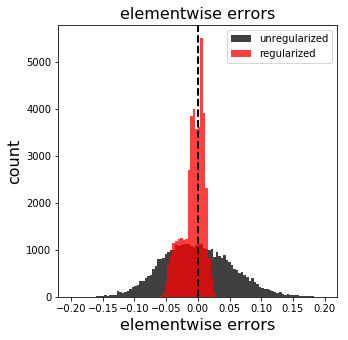

In [12]:
"""
Visualize results
"""

ll_mean = np.mean(log_likelihood_vals, axis=2)[:, 0]
ll_low = np.percentile(log_likelihood_vals, 50-75/2, axis=2)[:, 0]
ll_high = np.percentile(log_likelihood_vals, 50+75/2, axis=2)[:, 0]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(lambda_L_vals, ll_mean, label="mean")
ax.fill_between(x=lambda_L_vals, y1=ll_low, y2=ll_high, alpha=0.5, label="75% interval")
ax.set_xscale("log")
ax.set_xlabel("$\lambda_L$", fontsize=16)
ax.set_ylabel("log likelihood", fontsize=16)
ax.set_title("cross-validation log likelihood vs. $\lambda_L$", fontsize=16)
ax.legend(loc="lower center")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
rank_mean = np.mean(rank_vals, axis=2)[:, 0]
ax.plot(rank_mean, ll_mean)
ax.set_xlabel("mean rank", fontsize=16)
ax.set_ylabel("mean log likelihood", fontsize=16)
ax.set_title("cross-validation log likelihood vs. rank", fontsize=16)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
err_noreg = (sample_cov - true_cov).flatten()
err_reg = (cov_reg - true_cov).flatten()
ax.hist(err_noreg, range=(-0.2, 0.2), bins=100, label="unregularized", color="0.25")
ax.hist(err_reg, range=(-0.2, 0.2), bins=100, label="regularized", color="red", alpha=0.75)
ax.axvline(0, c="black", linestyle="--", linewidth=2)
ax.set_xlabel("elementwise errors", fontsize=16)
ax.set_ylabel("count", fontsize=16)
ax.set_title("elementwise errors", fontsize=16)
ax.legend()
plt.show()